In [3]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.nn as nn 
import numpy as np
import matplotlib.pyplot as plt

### Loading Data

In [4]:
training_data = datasets.mnist.FashionMNIST(root="data", train=True, download=True, transform=ToTensor())
test_data = datasets.mnist.FashionMNIST(root="data", train=False, download=True, transform=ToTensor())

In [5]:
training_data, validation_data = torch.utils.data.random_split(training_data, [50000, 10000])

In [6]:
print(len(training_data),len(validation_data),len(test_data))

50000 10000 10000


### CNN Baseline Model
Model with two CNN layers (including max pooling), one dense and an output classification layer, with suitable number of filters and units, respectively.

In [7]:
nClasses = 10
def cnn_model(nClasses):
    """
    Model with two CNN layers, one dense and an output classification layer, with suitable number of filters and units, respectively.
    :return:
    """
    ### YOUR CODE HERE
    class CNN(nn.Module):
        def __init__(self, nClasses):
            super(CNN, self).__init__()

            # First convolutional layer
            self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
            self.relu1 = nn.ReLU()
            # Max pooling layer
            self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

            # Second convolutional layer
            self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
            self.relu2 = nn.ReLU()
            self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

            # Fully connected layer/Dense Layer
            self.fc1 = nn.Linear(64 * 7 * 7, 128)  
            self.relu3 = nn.ReLU()

            # Output layer
            self.fc2 = nn.Linear(128, nClasses)  # 10 classes for FashionMNIST

        def forward(self, x):
            # First convolutional layer followed by max pooling
            x = self.pool1(self.relu1(self.conv1(x)))

            # Second convolutional layer followed by max pooling
            x = self.pool2(self.relu2(self.conv2(x)))

            # Flatten the tensor for the fully connected layer
            x = x.view(-1, 64 * 7 * 7)  

            # Fully connected layer
            x = self.relu3(self.fc1(x))

            # Output layer
            x = self.fc2(x)
            return x

    # Create an instance of the CNN model
    model = CNN(nClasses )
    return model

    ### YOUR CODE HERE


In [13]:
model = cnn_model(nClasses = 10)
from torchsummary import summary
summary(model, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          18,496
              ReLU-5           [-1, 64, 14, 14]               0
         MaxPool2d-6             [-1, 64, 7, 7]               0
            Linear-7                  [-1, 128]         401,536
              ReLU-8                  [-1, 128]               0
            Linear-9                   [-1, 10]           1,290
Total params: 421,642
Trainable params: 421,642
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.65
Params size (MB): 1.61
Estimated Total Size (MB): 2.26
-------------------------------------------

In [14]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='cpu')

In [15]:

# Move the model to the appropriate device
model.to(device)

# Now you can use this device for your data loading and training


CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

### Training

Implement the training / evaluation loop
Remember training / validation cost and accuracy per epoch and return them as list.

In [26]:
def train_eval(model, optimizer, nepochs, training_loader, validation_loader, scheduler=None):
    """
    Perform training and evaluation loop.
    :param model: Model to be trained
    :param optimizer: Optimiser to use for training
    :param nepochs: Number of epochs
    :param training_loader: Loader to provide mini-batches of training samples
    :param test_loader: Loader to provide mini-batches of validation samples
    :param scheduler: Scheduler used for a learning rate schedule
    :return: Lists with training and validation cost and accuracy per epoch.
    """
    cost_hist = []
    cost_hist_val = []
    acc_hist = []
    acc_hist_val = []

    cost_ce = torch.nn.CrossEntropyLoss()
        
    for epoch in range(nepochs):

        ### YOUR CODE HERE ###
        cost, acc = 0.0, 0.0
        nbatches = 0
        nbatches_val = 0

        # Training
        model.train()
        for batch, (X, Y) in enumerate(training_loader):
            pred = model(X)
            loss =cost_ce(pred, Y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            cost += loss.item() 
            acc += (pred.argmax(dim = 1) == Y).type(torch.float).mean().item()
            nbatches += 1
        
        cost /= nbatches
        acc /= nbatches

    # Evaluation on validation set

        cost_val, acc_val = 0.0, 0.0
        model.eval()
        with torch.no_grad():
            for batch, (Xval,Yval) in enumerate(validation_loader):
                pred_val = model(Xval)
                loss_val = cost_ce(pred_val, Yval)
                acc_val += (pred_val.argmax(dim = 1) == Yval).type(torch.float).mean().item()
                cost_val += loss_val.item()
                nbatches_val += 1
           
            cost_val /= nbatches_val
            acc_val /= nbatches_val

        print("Epoch %i: %f, %f, %f, %f"%(epoch, cost, acc, cost_val, acc_val))
        cost_hist.append(cost)
        cost_hist_val.append(cost_val)
        acc_hist.append(acc)
        acc_hist_val.append(acc_val)
        
        #scheduler.step()
    return cost_hist, cost_hist_val, acc_hist, acc_hist_val

### Train Baseline CNN Model

Follow the "Steps to Test and Tune a Model" as presented in the lecture.

Train the baseline with SGD without momentum and fixed learning rate. Tune the learning rate by this procedure.

Determine a suitable number of epochs.

In [27]:
### YOUR CODE HERE ###
n_epochs = 5
batch_size = 64
lr = 0.01
model = cnn_model(nClasses = 10)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0)


In [28]:
training_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=batch_size, shuffle=True)

In [13]:
### YOUR CODE HERE ###
cost_hist, cost_hist_val, acc_hist, acc_hist_val = train_eval(model, optimizer, n_epochs, training_loader, validation_loader)

Epoch 0: 0.450693, 0.835957, 0.680681, 0.775378
Epoch 1: 0.424041, 0.846707, 0.411093, 0.856588
Epoch 2: 0.405848, 0.852562, 0.511269, 0.802747
Epoch 3: 0.388852, 0.859495, 0.426364, 0.846835
Epoch 4: 0.375738, 0.864670, 0.389542, 0.859873


Text(0.5, 1.0, 'Accuracy')

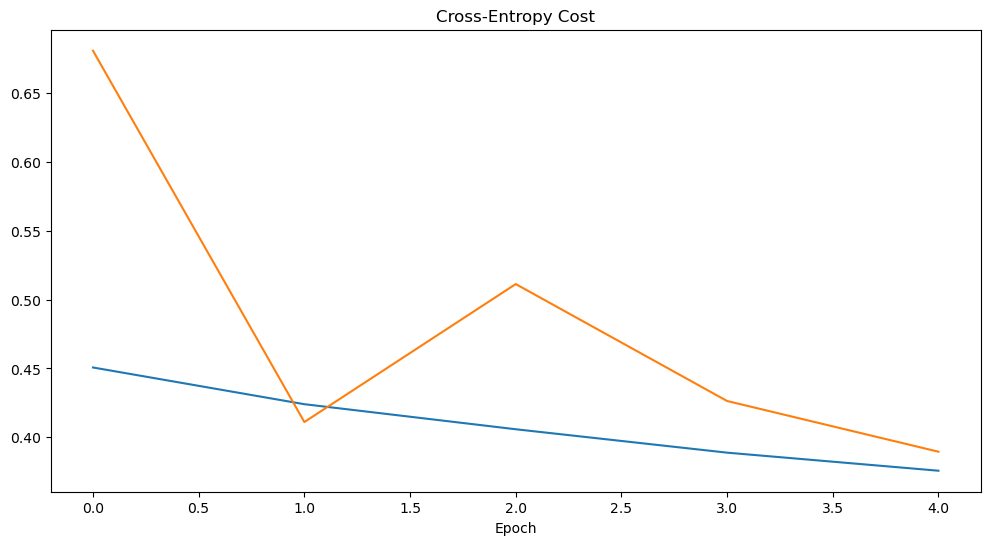

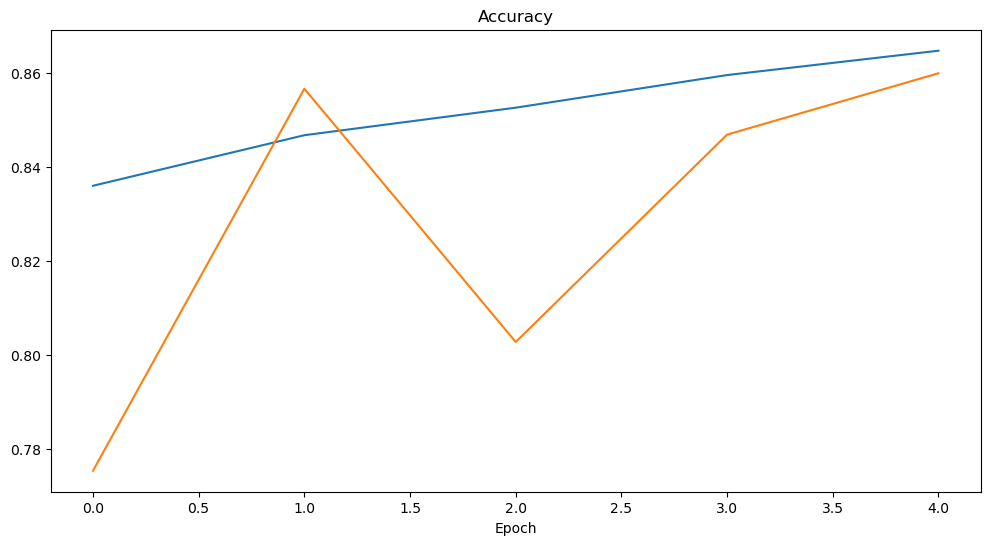

In [20]:
plt.figure(1, figsize=(12,6))
plt.plot(torch.arange(n_epochs), cost_hist, label='Training Loss')
plt.plot(torch.arange(n_epochs), cost_hist_val, label='Validation Loss' )
plt.xlabel("Epoch")
#plt.xlim(0,n_epochs)
#plt.ylim(0,1)
plt.title("Cross-Entropy Cost")
plt.figure(2, figsize=(12,6))
plt.plot(torch.arange(n_epochs), acc_hist, label='Training Accuracy')
plt.plot(torch.arange(n_epochs), acc_hist_val, label='Validation Accuracy')
plt.xlabel("Epoch")
#plt.xlim(0,nepn_epochsochs)
#plt.ylim(0.8,1)
plt.title("Accuracy")

### Cross-Validation

Use 5-fold cross validation to estimate the accuracy and an error bar of the accuracy estimate.


In [21]:
from torch.utils.data import SubsetRandomSampler, ConcatDataset
from sklearn.model_selection import KFold

In [28]:
### YOUR CODE HERE ###

def cross_validation(model, num_folds, batch_size, dataset, nepochs):
    # Define loss function and optimizer
    cost_ce = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

    # Initialize lists to store accuracy for each fold
    accuracies = []

    # Initialize KFold
    kf = KFold(n_splits=num_folds, shuffle=True)

    # Perform cross validation
    for fold, (train_indices, val_indices) in enumerate(kf.split(dataset)):
        print(f"Fold {fold + 1}")

        # Create DataLoader for training and validation using SubsetRandomSampler
        train_sampler = SubsetRandomSampler(train_indices)
        val_sampler = SubsetRandomSampler(val_indices)

        train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
        val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)

        # Training the model
        model.train()
        for epoch in range(nepochs):  # Example: 5 epochs
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = cost_ce(outputs, labels)
                loss.backward()
                optimizer.step()

        # Evaluating the model
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = correct / total
        accuracies.append(accuracy)
        print(f"Accuracy: {accuracy}")

    # Calculate mean accuracy and standard deviation
    mean_accuracy = np.mean(accuracies)
    print(f"Mean Accuracy: {mean_accuracy}")
          
    return mean_accuracy

In [29]:
dataset = ConcatDataset([training_data, validation_data])

avg_accuracy = cross_validation(model=model, num_folds=5, batch_size=64, dataset=dataset, nepochs=5)

Fold 1
Accuracy: 0.879
Fold 2
Accuracy: 0.8829166666666667
Fold 3
Accuracy: 0.8815833333333334
Fold 4
Accuracy: 0.8860833333333333
Fold 5
Accuracy: 0.89075
Mean Accuracy: 0.8840666666666666


### Analyse Different Optimisers with different Settings 

Use the code above to explore different settings for the different optimizers. Use batchsize 64.

1. *SGD*: Refer to the results from above - for later comparison.
<br>

2. *Momentum*: Play with at least three different settings when using momentum: learning rate, momentum parameter, Nesterov flag. Start with momentum=0.9 without Nesterov and suitable learning rate, then vary the momentum parameter and independently the learning rate. Can you see an impact of using Nesterov? What is your recommended best choice (lr, momentum, nesterov, nepochs) for the given problem?
<br>

3. *RMSProp*: Same thing now for RMSprop (without momentum). Play with at least three different settings when using RMSprop: lr, alpha. Start with the default settings of pytorch with (lr=0.01, alpha=0.99,centered=False). Then vary alpha and independently the learning rate. Can you see an impact when using centered=True? What is your recommended best choice (learning rate, alpha, centered, nepochs) for the given problem?<br>
<br>

4. *Adam*: Same thing now for Adam. Play with at least three different settings. Start with the default settings of pytorch. What is your recommended best choice for the given problem?<br>
<br>


In [ ]:
nbatch = 64
nepochs = 

training_loader = DataLoader(training_data, batch_size=nbatch, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=nbatch, shuffle=True)
    
model = mlp()
optimizer = ...
cost_hist, cost_hist_test, acc_hist, acc_hist_test = train_eval(model, optimizer, nepochs, training_loader, validation_loader)


### Plots and Comments (for the different steps described above) 

### Learning Rate Schedule

Modify your `train_eval` method implemented above to support using a learning rate schedule for SGD (without momentum) - by using e.g. StepLR. What are your preferred settings for the given task?

Compare and evaluate the training performance with the results obtained for the different optimizers above and provide a judgement.

In [20]:
n_epochs = 5
batch_size = 64
lr = 0.01
model = cnn_model(nClasses = 10)


In [30]:

optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.75)
cost_hist, cost_hist_val, acc_hist, acc_hist_val = train_eval(model, optimizer, n_epochs, training_loader, validation_loader, scheduler)

Epoch 0: 1.073973, 0.629955, 0.838708, 0.660330
Epoch 1: 0.653539, 0.757852, 0.748458, 0.717954
Epoch 2: 0.576728, 0.786265, 0.565085, 0.796079
Epoch 3: 0.527224, 0.807085, 0.713895, 0.715068
Epoch 4: 0.491009, 0.821731, 0.503406, 0.817675


Text(0.5, 1.0, 'Accuracy')

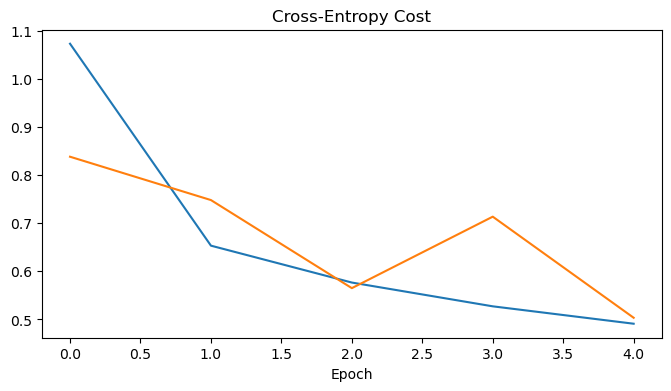

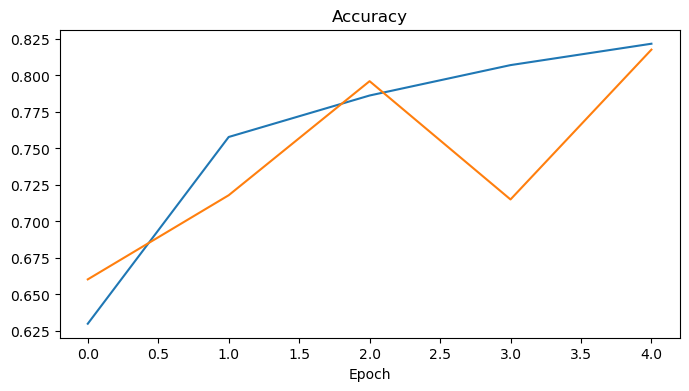

In [36]:
plt.figure(1, figsize=(8,4))
plt.plot(torch.arange(n_epochs), cost_hist, label='Training Loss')
plt.plot(torch.arange(n_epochs), cost_hist_val, label='Validation Loss' )
plt.xlabel("Epoch")
plt.title("Cross-Entropy Cost")

plt.figure(2, figsize=(8,4))
plt.plot(torch.arange(n_epochs), acc_hist, label='Training Accuracy')
plt.plot(torch.arange(n_epochs), acc_hist_val, label='Validation Accuracy')
plt.xlabel("Epoch")

plt.title("Accuracy")